<a href="https://www.kaggle.com/code/mikedelong/exploratory-data-visualization?scriptVersionId=136310253" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
filename = '../input/global-peace-index/peace_index.csv'
df = pd.read_csv(filepath_or_buffer=filename, delimiter=';', decimal=',')
group_filename = '../input/country-mapping-iso-continent-region/continents2.csv'
group_df = pd.read_csv(filepath_or_buffer=group_filename)
merged_columns = ['alpha-3', 'region']
merged_df = df.merge(right=group_df[merged_columns], how='inner', left_on='iso3c', right_on='alpha-3',).drop(columns=['alpha-3'])
merged_df.sample(5)

,Country,iso3c,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,region
72,Jamaica,JAM,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,1.201,Americas
57,Greece,GRC,1.620,1.426,1.437,1.448,1.460,1.460,1.661,1.661,1.661,1.851,1.840,1.828,1.817,1.805,1.805,1.805,Europe
128,Senegal,SEN,1.848,1.620,1.816,1.816,1.811,2.178,1.811,1.815,1.838,1.866,1.664,1.691,1.513,1.517,1.517,1.540,Africa
115,Philippines,PHL,1.950,2.178,2.189,2.248,2.146,2.165,2.345,2.387,2.370,2.398,2.224,2.384,2.245,2.261,2.274,2.230,Asia
51,Georgia,GEO,2.672,2.662,2.769,2.282,2.282,2.282,1.879,1.863,1.863,1.851,1.840,1.828,1.817,1.805,1.805,1.805,Asia


Let's make a year x country frame for plotting

In [2]:
# we have a few NAs so we need to fill/interpolate them before we try to run a clustering model
tsne_df = merged_df.drop(columns=['Country', 'iso3c', 'region']).fillna(method='pad', axis=0,)
tsne_df.isna().sum().sum()

0

Let's use t-SNE to project into a space we can visualize and then cluster using k-Means and tie the number of clusters to the number of regions

In [3]:
from math import sqrt
from plotly.express import scatter
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, random_state=1)
tsne_results = tsne.fit_transform(X=tsne_df.values)
kmeans = KMeans(n_init=10, n_clusters=merged_df['region'].nunique(), random_state=1)
kmeans.fit(X=merged_df.drop(columns=['Country', 'iso3c', 'region']).fillna(method='pad', axis=0,).values)
scatter(data_frame=pd.DataFrame(data={'Country': merged_df['Country'], 'region' : merged_df['region'], 'k-means': kmeans.labels_,
                                  'tsne 0': tsne_results[:, 0], 'tsne 1': tsne_results[:, 1], }), x='tsne 0', y='tsne 1', 
        hover_data='Country', color='k-means')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162 samples in 0.000s...
[t-SNE] Computed neighbors for 162 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 162 / 162
[t-SNE] Mean sigma: 0.562058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.819195
[t-SNE] KL divergence after 1000 iterations: 0.195188


For the most part the t-SNE projection and the k-means clusters find the same signal in the data, so we see the more peaceful countries mostly in the lower left (t-SNE) and near each other (k-means) and the less peaceful countries in the upper right (t-SNE) and near each other (k-means). Let's look at the t-SNE clusters on a regional (continental) basis.

In [4]:
scatter(data_frame=pd.DataFrame(data={'Country': merged_df['Country'], 'region' : merged_df['region'], 'k-means': kmeans.labels_,
                                  'tsne 0': tsne_results[:, 0], 'tsne 1': tsne_results[:, 1], }), x='tsne 0', y='tsne 1', 
        hover_data='Country', color='region')

If we squint we can see the European countries are more in the lower left; there's not much else we can say from looking at a plot. This really looks like a job for a violin plot.

In [5]:
# we need the transpose to get statistics in the year direction
plot_df = merged_df.drop(columns=['iso3c', 'region']).set_index(keys=['Country'], drop=True).T
violin_df = pd.concat([plot_df.mean(), plot_df.std()], axis=1).reset_index()
violin_df.columns = ['Country', 'mean', 'stddev']
violin_df['cluster'] = kmeans.labels_
violin_df = violin_df.merge(right=merged_df[['Country', 'region']], on='Country', how='inner')
violin_df.sample(5)

,Country,mean,stddev,cluster,region
157,Vietnam,1.377062,0.052827,1,Asia
82,Lebanon,2.591125,0.200650,4,Asia
117,Poland,1.369875,0.102760,1,Europe
142,Thailand,1.994438,0.125943,0,Asia
25,Chile,1.088125,0.163986,2,Americas


<Axes: xlabel='mean', ylabel='region'>

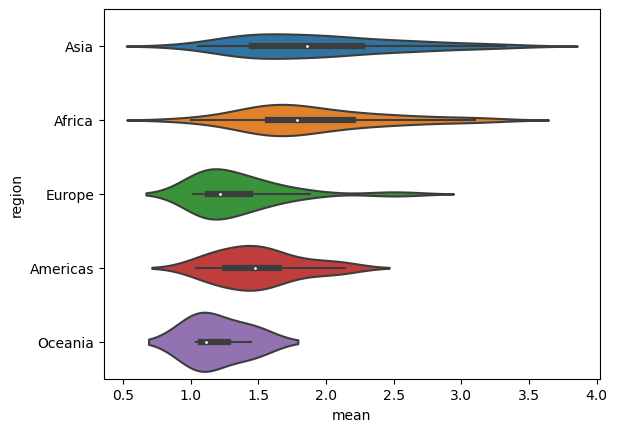

In [6]:
from seaborn import violinplot
violinplot(data=violin_df, x='mean', y='region')

In [7]:
scatter(data_frame=violin_df, x='mean', y='stddev', hover_data='Country', color='region')